# 真实世界图片分类器


## 加载和探索数据集
下载 horse-or-human.zip 文件，以下的 cell 主要功能是访问文件系统，以及对 zip 文件解压缩。

下载链接： https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip

In [1]:
import os
import pathlib
import tensorflow as tf
tf.config.experimental.list_physical_devices(device_type='GPU')

[]

.zip 的内容被解压到基本目录 ~/.keras/datasets/horses 和 ~/.keras/datasets/humans，目录里包含马和人类的图片。

注意：
   这个数据集中并没有明确的将图像标记为马或人。稍后你将学习使用 ImageGenerator，ImageGenerator会适当的标记图像，减少编码步骤。
   
首先，定义每个目录。

In [2]:
path_to_file = tf.keras.utils.get_file(
    'horse-or-human.zip',
    cache_subdir='horse-or-human',
    origin='http://aimaksen.bslience.cn/horse-or-human.zip',
    extract=True
)

现在，让我们看看马和人类训练目录中的文件名：

In [3]:
train_horses_dir = 'C:/Users/administrator/.keras/horse-or-human/horses'
train_humans_dir = 'C:/Users/Administrator/.keras/horse-or-human/humans'

In [4]:
train_horses_names = os.listdir(train_horses_dir)
print(train_horses_names[:10])

['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']


让我们找出目录中马和人图像的总数：

In [5]:
train_humans_names = os.listdir(train_humans_dir)
print(train_humans_names[:10])

['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']


我们再来看几张图片。 首先，配置matplot参数：

In [6]:
len(train_humans_names)

527

In [7]:
len(train_horses_names)

500

In [8]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

现在，显示一个 batch, 每个 batch 包含了8幅马和8幅人的图片。 您可以多次运行下面的单元格。

In [9]:
nrows = 4
ncols = 4
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)



<Figure size 1152x1152 with 0 Axes>

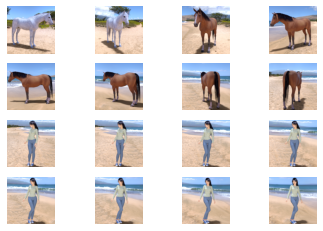

In [11]:
pic_index += 8
next_horses_pix = [
    os.path.join(train_horses_dir,fname) for fname in train_horses_names[pic_index - 8:pic_index]
]

next_humans_pix = [
    os.path.join(train_humans_dir,fname) for fname in train_humans_names[pic_index - 8:pic_index]
]


for i, img_path in enumerate(next_horses_pix + next_humans_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

## 从一个小模型开始搭建

先导入 tensorflow

In [12]:
import tensorflow as tf

### 数据处理

使用 ImageDataGenerator，用于一个批次一个批次的读取数据。每个批次有128张图片，每个图片 300X300。

[接口文档](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [14]:
train_data_gen = ImageDataGenerator(rescale = 1 / 255)

In [15]:
train_generator = train_data_gen.flow_from_directory(
    'C:/Users/administrator/.keras/horse-or-human',
    target_size = (300, 300),
    batch_size=128,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [16]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
train_generator.labels

array([0, 0, 0, ..., 1, 1, 1])

In [18]:
train_generator.filepaths[0]

'C:/Users/administrator/.keras/horse-or-human\\horses\\horse01-0.png'

### 搭建模型
我们先来搭建模型。

我们可以复用之前的 CNN 代码，并在原有基础上多加几层卷积和池化。

注意：
    horse-or-human 数据集对应的是二分类问题。所以在网络的最后一层，我们使用 sigmoid 激活函数。sigmoid 的输出是0/1。

In [19]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape=(300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.summary() 方法调用打印神经网络的网络层

In [20]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

Output Shape 列显示特征图的大小在连续层中的演变。


接下来编译模型，由于是二分类问题。所以我们使用的损失函数是 binary_crossentropy。在这里，我们使用了一个全新的优化器 RMSprop。


In [21]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate=0.001), metrics=['accuracy'])

我们训练15个 epoch —— 这可能需要几分钟才能运行。

In [22]:
history = model.fit(train_generator, steps_per_epoch=8,epochs = 5) 

Epoch 1/5
8/8 [==============================] - 16s 2s/step - loss: 3.9813 - accuracy: 0.5439
Epoch 2/5
8/8 [==============================] - 16s 2s/step - loss: 0.6662 - accuracy: 0.6741
Epoch 3/5
8/8 [==============================] - 16s 2s/step - loss: 0.8049 - accuracy: 0.6385
Epoch 4/5
8/8 [==============================] - 16s 2s/step - loss: 0.3535 - accuracy: 0.8721
Epoch 5/5
8/8 [==============================] - 16s 2s/step - loss: 0.2248 - accuracy: 0.9155


### 测试

让我们使用训练好的模型做预测。

In [26]:
import numpy as np
from keras.preprocessing import image

path = './horse.jpg'
img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = x / 255
x = np.expand_dims(x, axis = 0)
classes = model.predict(x, batch_size = 1)
print(classes[0])

if classes > 0.5:
    print('人')
else:
    print('马')

[0.03071481]
马


In [27]:
import numpy as np
from keras.preprocessing import image

path = './human.jpg'
img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = x / 255
x = np.expand_dims(x, axis = 0)
classes = model.predict(x, batch_size = 1)
print(classes[0])

if classes > 0.5:
    print('人')
else:
    print('马')

[7.572924e-07]
马


In [ ]:
classes

## 验证集使用

下载 validation-horse-or-human.zip 文件，以下的 cell 主要功能是访问文件系统，以及对 zip 文件解压缩。

下载链接：https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip 

看看马和人类训练、验证目录中的文件名

查看训练、验证目录中马和人图像总数

## 从一个小模型开始搭建

第一步 导入 tensorflow:

第二步 构建模型:

model.summary() 方法调用打印神经网络的网络层:

第三步 编译:

第四步 数据处理:

使用 ImageDataGenerator，用于一个批次一个批次的读取数据。每个批次有128张图片，每个图片 300X300。

第五步 训练模型:

第六步 预测:

清理

在运行下一个练习之前，运行以下单元格以终止内核并释放内存资源：

## 探索压缩图片带来的影响